In [18]:
import re

import ngrams as ngrams
import pandas as pd
from langdetect import detect
from bs4 import BeautifulSoup
import requests
import numpy as np
import nltk
import contractions
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet



## Inicjalizacja projektu
W tej części pobieramy potrzebne paczki do biblioteki nltk.
nltk wykorzystujemy w celu text processingu

In [19]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify
[nltk_data]     failed: unable to get local issuer certificate
[nltk_data]     (_ssl.c:1129)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>
[nltk_data] Error loading omw-1.4: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate 

False

## Funkcje pomocnicze
Dalej będą wykorzystywane w kodzie

In [20]:
import string
from nltk.corpus import wordnet

# Usuwa białe spacje i nowe linie
# Parametry
# content - string
# Zwrotka
# string
def trim_content(content: str) -> str:
    removed_spaces = re.sub("\s\s+" , " ", content)
    removed_new_lines = re.sub("\n" , "", removed_spaces)
    return removed_new_lines

# Filtrowanie list
# Zwraca wyfiltrowany obiekt według funkcji podanej w callbacku
# Parametry
# list_obj - lista do przefiltrowania
# callback - funkcja filtrująca, musi zwracać boolean
# Zwrotka
# Wyfiltrowany obiekt
def list_filter(list_obj, callback):
    new_list = list()

    for value in list_obj:
        if callback(value):
            new_list.append(value)

    return new_list

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_sentence(sentence, lemmatizer):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

def detect_language(text):
    try:
        language = detect(text)
    except:
        language = 'Other'
    return language

## Pobieranie danych z metacritic
Poniższy kod zwraca recenzje według podanych parametrów (niżej opisane w kodzie)
Kod został dostosowany na potrzeby serwisu metacritic.com
Metacritic blokuje zbyt częste requesty co zostało uwzględnione dalej w kodzie (poniżej odpowiednio opisane)

In [35]:
import pandas as pd
from bs4 import BeautifulSoup
import requests

# Pobieranie danych z metacritic

class MetacriticData:
    def __init__(self):
        self.DEFAULT_RESPONSE = 'Unknown' # Teksotowa zwrotka w przypadku gdy nie ma wystarczającej ilości danych. Wykorzystujemy to dalej by wykryć sytuacje w których kod zadziała w nieoczekiwany sposób przez brak danych na stronie
        self.DEFAULT_RESPONSE_FLOAT = float(-1) # Liczbowa zwrotka w przypadku gdy nie ma wystarczającej ilości danych. Wykorzystujemy to dalej by wykryć sytuacje w których kod zadziała w nieoczekiwany sposób przez brak danych na stronie
        self.search_url = "https://www.metacritic.com/autosearch" # Endpoint do wyszukiwania tytułów
        self.search_headers = { # Nagłówki do zapytania wyszukiwania, bez tego przeglądarka myśli, że jesteśmy robotem i blokuje requesty. Skopiowane z zapytania przeglądarki
            'authority': 'www.metacritic.com',
            'accept': '*/*',
            'x-requested-with': 'XMLHttpRequest',
            'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) '
                        'Chrome/95.0.4638.54 Safari/537.36',
            'content-type': 'application/x-www-form-urlencoded; charset=UTF-8',
            'sec-gpc': '1',
            'origin': 'https://www.metacritic.com',
            'sec-fetch-site': 'same-origin',
            'sec-fetch-mode': 'cors',
            'sec-fetch-dest': 'empty',
            'referer': 'https://www.metacritic.com/game/playstation-4/grand-theft-auto-v',
            'accept-language': 'en-GB,en-US;q=0.9,en;q=0.8',
            'cookie': 'mc_s_s=d_2; OptanonAlertBoxClosed=2021-10-31T12:22:29.841Z; '
                    'ctk=NjE3ZThhOTEwMjAwMDAwMGRmN2Q3M2I4NmRiMg%3D%3D; omniEvents[pageFindingMethod]=Internal:Search; '
                    '_BB.bs=a|3; metapv=3; _BB.d=0|||2; '
                    'OptanonConsent=isIABGlobal=false&datestamp=Sun+Oct+31+2021+13%3A23%3A10+GMT%2B0100+('
                    'Central+European+Standard+Time)&version=6.20.0&hosts=&consentId=316c06a0-7ce1-4feb-8905-2c9cfeec47a2'
                    '&interactionCount=1&landingPath=NotLandingPage&groups=C0001%3A1%2CC0002%3A1%2CC0003%3A1%2CC0004%3A1'
                    '&geolocation=PL%3B24&AwaitingReconsent=false '
        }
        # @TODO: Być może można to usunąć i korzystać z jednego headera
        self.web_scrapping_headers = { # Nagłówki do zapytania pobierania recenzji, bez tego przeglądarka myśli, że jesteśmy robotem i blokuje requesty. Skopiowane z zapytania przeglądarki
            'authority': 'www.metacritic.com',
            'cache-control': 'max-age=0',
            'upgrade-insecure-requests': '1',
            'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) '
                        'Chrome/95.0.4638.54 Safari/537.36',
            'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,'
                    'application/signed-exchange;v=b3;q=0.9',
            'sec-gpc': '1',
            'sec-fetch-site': 'same-origin',
            'sec-fetch-mode': 'navigate',
            'sec-fetch-user': '?1',
            'sec-fetch-dest': 'document',
            'referer': 'https://www.metacritic.com/game/playstation-4/grand-theft-auto-v',
            'accept-language': 'en-GB,en-US;q=0.9,en;q=0.8',
            'cookie': 'mc_s_s=d_2; OptanonAlertBoxClosed=2021-10-31T12:22:29.841Z; '
                    'ctk=NjE3ZThhOTEwMjAwMDAwMGRmN2Q3M2I4NmRiMg%3D%3D; _BB.bs=a|3; metapv=11; _BB.d=0|||10; '
                    'OptanonConsent=isIABGlobal=false&datestamp=Sun+Oct+31+2021+16%3A12%3A56+GMT%2B0100+('
                    'Central+European+Standard+Time)&version=6.20.0&hosts=&consentId=316c06a0-7ce1-4feb-8905-2c9cfeec47a2'
                    '&interactionCount=1&landingPath=NotLandingPage&groups=C0001%3A1%2CC0002%3A1%2CC0003%3A1%2CC0004%3A1'
                    '&geolocation=PL%3B24&AwaitingReconsent=false '
        }

    def _select_content(self, web_content: str) -> str: # Metoda, która zwraca zawartość tekstową strony lub standardową odpowiedź w przypadku nie wykrycia contentu
        if len(web_content) > 0:
            return web_content[0].text
        else:
            return self.DEFAULT_RESPONSE
        
    def _select_content_as_number(self, web_content: str, default_value: int = int(-1)) -> int: # Metoda, która zwraca zawartość tekstową strony w formie liczby lub standardową odpowiedź w przypadku nie wykrycia contentu
        if len(web_content) > 0:
            try:
                return int(web_content[0].text)
            except: 
                return default_value
        
        else:
            return default_value
        
    def _select_reliability(self, ups: str, thumbs: str) -> float: # Wykrywania wiarygodności ocen. Oceniane w sposób podzielenia łapek w górę w stosunku do łapek w dół. Skala 1-0, gdzie 1 tj. wiarygodna 0 tj. mało wiarygodna. W przypadku braku informacji zwraca defaultową odpowiedź
        try:
            reliability = int(ups) / int(thumbs)
    
            return reliability
        except:
            return self.DEFAULT_RESPONSE_FLOAT
        
    def search(self, title: str, platform: str = "PC Game") -> str: # Odpytanie o wyniki wyszukiwania, title - tytuł gry, platform - platforma do recenzji (Defaultowo: PC Game)
        payload = "search_term=" + title + "&image_size=98&search_each=true" # Payload potrzebny do requestu (wykorzystuje tytuł gry)
        response = requests.request("POST", self.search_url, headers=self.search_headers, data=payload) # Zwrotka z pobranymi danymi. Wykorzystuje nagłówki i powyższy payload
        results = response.json()['autoComplete']['results'] # Zwrotka przetworzona, która zwraca tylko wyniki wyszukiwania (Klucze są ID-kami tagów na stronie metacritic)
        selected_platform_results = list_filter(results, lambda elem: elem['refType'] == platform) # Filtrowanie wyników tylko dla wyszukiwanej platformy. Wybranej w parametrze plarform
        exact_title_selected_platform_results = list_filter(selected_platform_results, lambda elem: elem['name'] == title) # Filtrowanie wyników dla tytułów. Wybranego w parametrze title

        if len(exact_title_selected_platform_results) <= 0:
            raise ValueError('The title \'' + title + '\' on platform \'' + platform + '\' was not found.') # W przypadku braku wyników kod zaprzestaje dalszego wywołania

        return exact_title_selected_platform_results[0] # Zwraca pierwszy znaleziony wynik na stronie
    
    def web_scrapping(self, base_url: str, endpoint: str, pages_enabled: bool = False) -> list: # Pobieranie recenzji. Funkcja zwraca listę recenzji znaleziony na stronie gry. base_url - adres strony gry, endpoint - dalsza część adresu odpytania np. podstrona recenzji krytyków lub graczy, pages_enabled - informacja czy paginacja występuje na stronie
        if pages_enabled: # Niektóre strony zawierają paginację, przez co kod musi działać w inny sposób by pobrać wszystkie wyniki.
            have_content = True # Wartość, która pozwala na wykrywania jak długo strona zawiera kolejne dane. Metacritic zwraca kod 200 (OK) dla stron, które nie mają żadnych recenzji, więc nei możńa wykrywać kodu response'a.
            page_index = 0 # Index strony na której się znajdujemy
            response = list() # Zebrane wszystkie recenzje
        
            while have_content: # Dopóki mamy content na stronach
                url = base_url + endpoint + '?page=' + str(page_index) # URL z dodanym parametrem strony
                request = requests.request("GET", url, headers=self.web_scrapping_headers) # Pobieranie zawartości strony
                request_text = request.text # Zawartość strony w formie tekstowej

                if request.status_code != 200: # Jeśli strona metacritic zwróci kod błędu inny niż 200, program zaprzestaje działania. Oznacza to, że nie ma wyników dla wyszukiwanej gry lub metacritic nieodpowiada
                    raise ValueError('Cannot fetch reviews for \'' + url + '\'.')

                if page_index > 50: # Zabezpieczenie przed infinity loopem. Korzystamy tutaj z while'a, wiec warto dodać takie podwójne zabezpieczneie
                    raise ValueError('Probably fetched too many pages for \'' + url + '\'.')

                if 'There are no user reviews yet -' in request_text: # Wykrywa czy istnieje podana fraza na stronie, która wskazuje na to, że nie ma więcej stron
                    have_content = False
                else:
                    response.append(request_text) # Dodaje zwrotkę do arraya response'a, który jest zwracany po wykonaniu pętli

                page_index += 1 # Zwiększenie indeksu strony
            
            return response # Zwracanie znalezionych wyników wyszukiwania

        else: # W przypadku gdy nieoczekujemy paginacji na stronie
            url = base_url + endpoint # Endpoint w tym przypadku bez parametru strony
            request = requests.request("GET", url, headers=self.web_scrapping_headers) # Pobieranie danych

            if request.status_code != 200: # Jeśli strona metacritic zwróci kod błędu inny niż 200, program zaprzestaje działania. Oznacza to, że nie ma wyników dla wyszukiwanej gry lub metacritic nieodpowiada
                raise ValueError('Cannot fetch reviews for \'' + url + '\'.')

            return [request.text] # Zwracanie wyniku w formie arraya, żeby utrzymać spójność zwrokti kodu
        

    def find_reviews(self, web_contents: list, expert: bool = False) -> list: # Wyszukiwanie recenzji na stronie. Parametry: web_contents - lista tekstowej zawartości stron, expert - zdefiniowanie czy szukamy wyników dla recenzji ekspertów czy graczy (true - expert, false - gracz, defaultowo: false - gracz). # Zwraca odpowiedź w formie listy gdzie pierwszy elementr to recenzje krytyków a drugi to recenzje graczy.
        response = list() # Lista znalezionych wyników

        for web_content in web_contents: # Pętla listująca się po podanych contentach strony
            soup = BeautifulSoup(web_content, 'html.parser') # Stworzenie "zupy", z podanych treści, przetwarza nam to HTML-a i dalej możemy łatwiej wyszukiwać zawartości
            main_content = soup.findAll('div', attrs={"id": "main"}) # Wyszukanie głównej zawartości strony
            print("main_content")
            soup_main = BeautifulSoup(str(main_content), 'html.parser') # Stworzenie "zupy", z podanych treści, przetwarza nam to HTML-a i dalej możemy łatwiej wyszukiwać zawartości
            print("soup_main")
            reviews_elements = soup_main.findAll('li', attrs={"class": "review"}) # Wyszukanie wszystkich wyników recenzji

            for review in reviews_elements: # Pętla listująca się po znalezionych recenzjach
                soup_child = BeautifulSoup(str(review), 'html.parser') # Stworzenie "zupy", z podanych treści, przetwarza nam to HTML-a i dalej możemy łatwiej wyszukiwać zawartości
                review_score = self._select_content(soup_child.findAll('div', attrs={"class": "metascore_w"})) # Ocena liczbowa metacritic
                review_content = self._select_content(soup_child.findAll('div', attrs={"class": "review_body"})) # Zawartość
                review_source = self._select_content(soup_child.findAll('div', attrs={"class": "source"})) # Źródło recenzji, występuje tylko dla expertów
                review_name = self._select_content(soup_child.findAll('div', attrs={"class": "name"})) # Nazwa recenzjenta
                review_date = self._select_content(soup_child.findAll('div', attrs={"class": "date"})) # Data recenzji
                review_ups = self._select_content_as_number(soup_child.findAll('span', attrs={"class": "total_ups"}), int(0)) # Ilość łapek w górę
                review_thumbs = self._select_content_as_number(soup_child.findAll('span', attrs={"class": "total_thumbs"}), int(0)) # Ilość wszystkich łapek, nie dostajemy informacji o łapkach w dół
                review_reliabilty = self._select_reliability(review_ups, review_thumbs) # Wiarygodność recenzji

                if expert: # Odopwiednie dodawanie zwrotki zależności czy korzystamy z opinii ekspertów czy graczy. Opinie ekspertów nie mogą być np. oceniane przez innych
                    response.append({
                        'name': trim_content(review_source), 
                        'date': trim_content(review_date),
                        'score': trim_content(review_score), 
                        'content': trim_content(review_content), 
                    })
                else:
                    response.append({
                        'name': trim_content(review_name), 
                        'date': trim_content(review_date),
                        'score': trim_content(review_score), 
                        'content': trim_content(review_content), 
                        'ups': review_ups, 
                        'thumbs': review_thumbs, 
                        'reliability': review_reliabilty
                    })

        print("Hello")
        return response # Zwrócenie znalezionych recenzji

    def get_reviews(self, title: str, platform: str = 'PC Game') -> list: # Pobieranie recenczji na danej stronie
        results = self.search(title, platform) # Wyszukiwanie konkretnych tytułów (patrz na metodę search)

        scrapped_critic_review = self.web_scrapping(results['url'], '/critic-reviews', False) # Uruchomienie webscrappingu po znalezionych wynikach tytułów - dla recenzji ekspertów. Nie zawierają paginacji. Informację o paginacji niestety możemy tylko ręcznie sprawdzić na stronie metacritic.
        scrapped_user_review = self.web_scrapping(results['url'], '/user-reviews', True) # Uruchomienie webscrappingu po znalezionych wynikach tytułów - dla recenzji graczy. Zawierają paginację. Informację o paginacji niestety możemy tylko ręcznie sprawdzić na stronie metacritic.

        critic_reviews = pd.DataFrame(self.find_reviews(scrapped_critic_review, True)) # Zebrane opinie ekspertów w formie dataframe'a
        user_reviews = pd.DataFrame(self.find_reviews(scrapped_user_review)) # Zebrane opinie graczy w formie dataframe'a

        return [critic_reviews, user_reviews] # Zwraca odpowiedź w formie listy gdzie pierwszy elementr to recenzje krytyków a drugi to recenzje graczy.

    MetacriticData().get_reviews('Mafia: Definitive Edition', 'PC Game')

IndexError: list index out of range

## Wyszukiwanie opinii graczy potrzebnych do dalszej części przetwarzania
W kolejnym etapie kodu zapisujemy do odpowiedniej DF-ki opinie graczy. Opinie ekspertów finalnie okazały się zbędne i niepotrzebujemy ich dalej przetwarzać. Wyświetlamy w wynikach cell-ki przykładowego zbioru recenzji.

In [22]:
def changeScore(df, columnInput, columnOutput):
    df[columnOutput] = np.where(
    df[columnInput].astype(int) <= 4 , "negatywna", np.where(
    df[columnInput].astype(int) >= 8, "pozytywna", "neutralna"))
    return df

import seaborn as sns

def createPlotTypeofComment(df,column, title):
    sns.set_style("white")

    ax = sns.countplot(y=column, data=df, palette = 'magma')
    for container in ax.containers:
        ax.bar_label(container)
    sns.despine(bottom = True, left = True)
    ax.set(xlabel='Ilość', ylabel='Ocena')
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_title(title)

def changeLanguage(df, column):
    df['Language'] = df[column].apply(detect_language)
    df = df.loc[df['Language'] == "en"]
    df = df.reset_index(drop=True)
    return df

In [32]:
#Mafia opinie
MetacriticData().get_reviews('Mafia: Definitive Edition', 'PC Game')
# df_user_review_mafia_definitive_edition_pc = MetacriticData().get_reviews('Mafia: Definitive Edition', 'PC Game')[1]


IndexError: list index out of range

In [ ]:
df_user_review_mafia_definitive_edition_pc = changeLanguage(df_user_review_mafia_definitive_edition_pc, "content")
df_user_review_mafia_definitive_edition_pc = changeScore(df_user_review_mafia_definitive_edition_pc, "score", "desc")
createPlotTypeofComment(df_user_review_mafia_definitive_edition_pc, "desc", 'Ilość recenzji dla Mafia Definitive Edition PC')

In [24]:
#Fifa Opinie
df_user_review_Fifa_20 = MetacriticData().get_reviews('FIFA 20', 'PS4 Game')[1]
df_user_review_Fifa_20 = changeLanguage(df_user_review_Fifa_20, "content")
df_user_review_Fifa_20 = changeScore(df_user_review_Fifa_20, "score", "desc")
createPlotTypeofComment(df_user_review_Fifa_20, "desc", 'Ilość recenzji dla FIFA 20')

IndexError: list index out of range

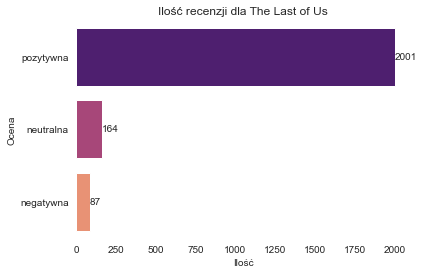

In [11]:
df_user_review_The_last_of_us = MetacriticData().get_reviews('The Last of Us', 'PS3 Game')[1]
df_user_review_The_last_of_us = changeLanguage(df_user_review_The_last_of_us, "content")
df_user_review_The_last_of_us = changeScore(df_user_review_The_last_of_us, "score", "desc")
createPlotTypeofComment(df_user_review_The_last_of_us, "desc", 'Ilość recenzji dla The Last of Us')

In [ ]:
df_user_review_mafia_definitive_edition_pc.to_excel ("mafianew.xlsx", index = True, header=True)
df_user_review_The_last_of_us.to_excel ("thelastofusnew.xlsx", index = True, header=True)
df_user_review_Fifa_20.to_excel ("fifa20new.xlsx", index = True, header=True)

In [18]:
def preprocessing(df):

    lemmatizer = nltk.stem.WordNetLemmatizer()
    # change text to lower
    df["text_preprocessing"] = df["content"].str.lower()
    #remove mafia
    df["text_preprocessing"] = df["text_preprocessing"].str.replace("mafia", "game")
    df["text_preprocessing"] = df["text_preprocessing"].str.replace("fifa", "game")
    df["text_preprocessing"] = df["text_preprocessing"].str.replace("fifa20", "game")
    df["text_preprocessing"] = df["text_preprocessing"].str.replace("thelastofus", "game")
    df["text_preprocessing"] = df["text_preprocessing"].str.replace("the last of us", "game")
    #hadn't to had not
    df["text_preprocessing"] = df["text_preprocessing"].apply(lambda x: [contractions.fix(word) for word in x.split()])
    df["text_preprocessing"] = [' '.join(map(str, l)) for l in df["text_preprocessing"]]
    #remove punctuation
    df["text_preprocessing"] = df["text_preprocessing"].apply(lambda x: remove_punctuation(x))
    #remove numbers
    df["text_preprocessing"] = df["text_preprocessing"].str.replace('\d+', '')
    df["text_preprocessing"] = df["text_preprocessing"].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')
    #remove double spaces
    df["text_preprocessing"] = df["text_preprocessing"].str.replace("\s\s+", " ")
    #remove stopwords
    df["text_preprocessing"] = df["text_preprocessing"].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in ENGLISH_STOP_WORDS]))
    #tokenization and lemmatization
    df["text_preprocessing"] = df["text_preprocessing"].apply(lambda x: lemmatize_sentence(x, lemmatizer))


    return df

In [19]:
df_user_review_mafia_definitive_edition_pc_preprocessed = preprocessing(df_user_review_mafia_definitive_edition_pc)
df_user_review_mafia_definitive_edition_pc_preprocessed

/var/folders/gt/t4t7vkc10wj1379qplxkdq9h0000gn/T/ipykernel_79343/1368659821.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  df["text_preprocessing"] = df["text_preprocessing"].str.replace('\d+', '')
/var/folders/gt/t4t7vkc10wj1379qplxkdq9h0000gn/T/ipykernel_79343/1368659821.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df["text_preprocessing"] = df["text_preprocessing"].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')
/var/folders/gt/t4t7vkc10wj1379qplxkdq9h0000gn/T/ipykernel_79343/1368659821.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  df["text_preprocessing"] = df["text_preprocessing"].str.replace("\s\s+", " ")


,name,date,score,content,ups,thumbs,reliability,Language,desc,text_preprocessing
0,welling,"Dec 6, 2020",5,Speaking of cut content... didn't they say it ...,58,58,1.000000,en,neutralna,speak cut content do say expand kind new missi...
1,beltaniasa,"Oct 31, 2020",3,"But since its a remake, I must rate it in comp...",18,19,0.947368,en,negatywna,remake rate comparsion original game new versi...
2,prasannasai,"Sep 26, 2020",10,This is how you do a remake. I know hangar 13 ...,32,50,0.640000,en,pozytywna,remake know hangar do budget rockstar do best ...
3,marganezz1,"Aug 29, 2020",5,"The game is called a remake, but this is just ...",31,66,0.469697,en,neutralna,game call remake just mediocre game base game ...
4,DjBarbarossa,"Nov 15, 2020",6,"The scenario MAF-DE, as in most cases of the e...",9,9,1.000000,en,neutralna,scenario mafde case entire game animate cutsce...
...,...,...,...,...,...,...,...,...,...,...
356,spanks_out,"May 13, 2022",0,This is a slap in the face for Mafia fans out ...,0,0,-1.000000,en,negatywna,slap face game fan therethis just overtutorial...
357,PETRAKITO,"Jun 2, 2022",10,"Its interesting :) Its a good story, malko har...",0,0,-1.000000,en,pozytywna,interest good story malko hard drive well driv...
358,TommyShelby_,"May 29, 2022",8,First time playing Mafia series and can say th...,0,0,-1.000000,en,pozytywna,time play game series say like game story tomm...
359,ln3,"Jun 21, 2022",10,"Amazing graphics and atmosphere, wonderful fac...",0,0,-1.000000,en,pozytywna,amaze graphic atmosphere wonderful face work a...


In [20]:
df_user_review_The_last_of_us_preprocessed = preprocessing(df_user_review_The_last_of_us)
df_user_review_The_last_of_us_preprocessed

/var/folders/gt/t4t7vkc10wj1379qplxkdq9h0000gn/T/ipykernel_79343/1368659821.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  df["text_preprocessing"] = df["text_preprocessing"].str.replace('\d+', '')
/var/folders/gt/t4t7vkc10wj1379qplxkdq9h0000gn/T/ipykernel_79343/1368659821.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df["text_preprocessing"] = df["text_preprocessing"].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')
/var/folders/gt/t4t7vkc10wj1379qplxkdq9h0000gn/T/ipykernel_79343/1368659821.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  df["text_preprocessing"] = df["text_preprocessing"].str.replace("\s\s+", " ")


,name,date,score,content,ups,thumbs,reliability,Language,desc,text_preprocessing
0,brad3ngunn,"Jun 14, 2013",10,I don't know what I can really say about this ...,313,407,0.769042,en,pozytywna,know really say game give away tell easily gam...
1,Badonkadonk,"Jun 15, 2013",10,"I wouldn't call this game perfect, but it's pr...",65,85,0.764706,en,pozytywna,game perfect pretty close wanted rate closer o...
2,jakenelson,"Jun 18, 2013",10,I don't think I have ever played a game like t...,29,38,0.763158,en,pozytywna,think played game like say game great understa...
3,Qishere,"Jun 14, 2013",10,"You should realize right from the beginning, y...",69,92,0.750000,en,pozytywna,realize right begin dark remorseless journey s...
4,journeyfreak787,"Jun 14, 2013",10,This game truly is phenomenal. Naughty Dog pro...,106,143,0.741259,en,pozytywna,game truly phenomenal naughty dog prove king p...
...,...,...,...,...,...,...,...,...,...,...
2247,Fraru,"Jun 8, 2022",9,"good game, good narrative, a good director's g...",0,0,-1.000000,en,pozytywna,good game good narrative good director game th...
2248,lookidont,"Jun 9, 2022",10,this game is going to be remember as a good cl...,0,0,-1.000000,en,pozytywna,game go remember good classic whit amaze narra...
2249,Potreen,"Jun 14, 2022",10,This game opened a new door for the gaming ind...,0,0,-1.000000,en,pozytywna,game open new door gaming industry show people...
2250,FilipeMCM,"Jun 13, 2022",10,"This review contains spoilers, click expand t...",0,0,-1.000000,en,pozytywna,review contain spoiler click expand view buy g...


In [21]:
df_user_review_Fifa_20_preprocessed = preprocessing(df_user_review_Fifa_20)
df_user_review_Fifa_20_preprocessed

/var/folders/gt/t4t7vkc10wj1379qplxkdq9h0000gn/T/ipykernel_79343/1368659821.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  df["text_preprocessing"] = df["text_preprocessing"].str.replace('\d+', '')
/var/folders/gt/t4t7vkc10wj1379qplxkdq9h0000gn/T/ipykernel_79343/1368659821.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df["text_preprocessing"] = df["text_preprocessing"].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')
/var/folders/gt/t4t7vkc10wj1379qplxkdq9h0000gn/T/ipykernel_79343/1368659821.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  df["text_preprocessing"] = df["text_preprocessing"].str.replace("\s\s+", " ")


,name,date,score,content,ups,thumbs,reliability,Language,desc,text_preprocessing
0,rumbledore,"Sep 24, 2019",0,EA Just gives us the same game every year with...,67,67,1.0,en,negatywna,ea just give game year minor change care
1,budz007,"Sep 25, 2019",0,I see all these comments saying not to listen ...,50,50,1.0,en,negatywna,comment say listen criticism tell listen star ...
2,Gfassina99,"Sep 24, 2019",0,EA excels at every game manipulating games and...,39,39,1.0,en,negatywna,ea excels game manipulate game player mentalit...
3,PhillsAcer,"Sep 26, 2019",0,This game hasn't changed since 2017! Just a fe...,32,32,1.0,en,negatywna,game change just mode core gameplay bad demo p...
4,Hangar18,"Sep 24, 2019",0,A shocker!! How can anyone give this game more...,26,26,1.0,en,negatywna,shocker game unless ea payroll young comprehen...
...,...,...,...,...,...,...,...,...,...,...
1410,Nilondon777,"Nov 3, 2021",6,its game with male and female football with in...,0,0,-1.0,en,neutralna,game male female football international cup wo...
1411,LeiKazama,"Oct 27, 2021",0,career in fifa for one player - a piece of cod...,0,0,-1.0,en,negatywna,career game player piece code create fortran c...
1412,Rnoviok,"Dec 4, 2021",1,The third Fifa I've played and the first in wh...,0,0,-1.0,en,negatywna,game play tried ultimate team mode probably buy
1413,Ferman,"Feb 12, 2022",3,Games from electronic arts are the worst sport...,0,0,-1.0,en,negatywna,game electronic art bad sport simulator play a...


In [22]:
#Najczęstsze słowa
from collections import Counter
def calculateOccurence(df, column):

    cnt = Counter()
    for text in df[column].values:
        for word in text.split():
            cnt[word] += 1
        
    df = pd.DataFrame(cnt.most_common(20))
    df.index = df.iloc[:,0]
    return df


In [27]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

def createPlotwithOccurence(df, title):

    ax = df.plot(kind='barh', figsize=(8, 10), color='#86bf91', zorder=1, width=0.8)

    # Draw vertical axis lines
    vals = ax.get_xticks()
    for tick in vals:
        ax.axvline(x=tick, linestyle='dashed', alpha=0.8, color='#eeeeee', zorder=1)

      # Set x-axis label
    ax.set_xlabel("Ilość występowania słów", labelpad=20, weight='bold', size=16)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
      # Set y-axis label
    ax.set_ylabel("Słowo", labelpad=20, weight='bold', size=16)

      # Format y-axis label
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
    ax.get_legend().remove()
    ax.set_title(title,  weight='bold', size=16)

ILOŚC występowania słów

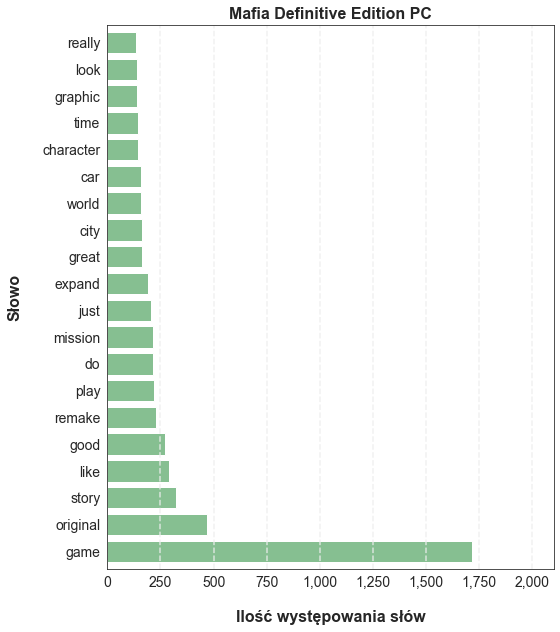

In [24]:
df_user_review_mafia_count = calculateOccurence(df_user_review_mafia_definitive_edition_pc_preprocessed,"text_preprocessing")
createPlotwithOccurence(df_user_review_mafia_count, "Mafia Definitive Edition PC")

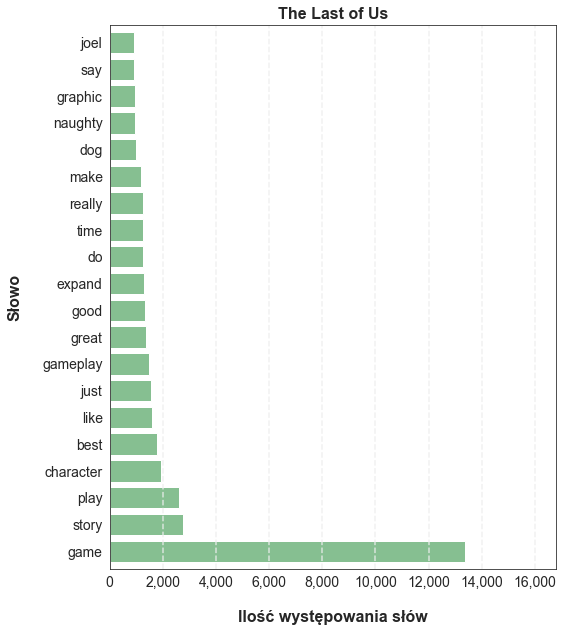

In [25]:
df_user_review_The_last_of_us_count = calculateOccurence(df_user_review_The_last_of_us_preprocessed,"text_preprocessing")
createPlotwithOccurence(df_user_review_The_last_of_us_count, "The Last of Us" )

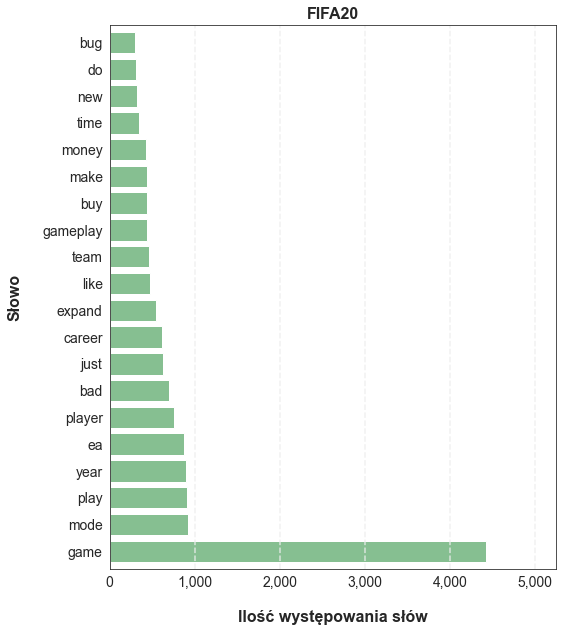

In [26]:
df_user_review_Fifa_20_count = calculateOccurence(df_user_review_Fifa_20_preprocessed,"text_preprocessing")
createPlotwithOccurence(df_user_review_Fifa_20_count, "FIFA20" )

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def calculateCountVectorizer(df, column, range_from, range_to):
    vectorizer = CountVectorizer(ngram_range = (range_from,range_to))
    X = vectorizer.fit_transform(df[column]).toarray()
    pd.DataFrame(X, columns = vectorizer.get_feature_names())
    counts = pd.DataFrame(X[0].T, index=vectorizer.get_feature_names(), columns=["Count Vectorizer"]).sort_values('Count Vectorizer', ascending=False)
    return vectorizer, X ,counts

def calculateTFIDF(df, column):

    tfidf = TfidfVectorizer()
    transformed = tfidf.fit_transform(df[column]).toarray()
    pd.DataFrame(transformed, columns =  tfidf.get_feature_names())
    counts = pd.DataFrame(transformed[0].T, index=tfidf.get_feature_names(), columns=["TF-IDF"]).sort_values('TF-IDF', ascending=False)
    return tfidf, transformed ,counts

def CountVectorizerplot(df, title):

    ax = df.head(20).plot(kind='barh', figsize=(8, 10), color='#C70039', zorder=1, width=0.8)
    # Draw vertical axis lines
    vals = ax.get_xticks()
    for tick in vals:
        ax.axvline(x=tick, linestyle='dashed', alpha=0.8, color='#eeeeee', zorder=1)

          # Set x-axis label
    ax.set_xlabel("Ilość występowania frazy", labelpad=20, weight='bold', size=16)

          # Set y-axis label
    ax.set_ylabel("Fraza", labelpad=20, weight='bold', size=16)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

          # Format y-axis label
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
    ax.get_legend().remove()
    ax.set_title(title,  weight='bold', size=16)

def Tfidfrplot(df, title):

    ax = df.head(20).plot(kind='barh', figsize=(8, 10), color='#C70039', zorder=1, width=0.8)
    # Draw vertical axis lines
    vals = ax.get_xticks()
    for tick in vals:
        ax.axvline(x=tick, linestyle='dashed', alpha=0.8, color='#eeeeee', zorder=1)

          # Set x-axis label
    ax.set_xlabel("Istotność słowa", labelpad=20, weight='bold', size=16)

          # Set y-axis label
    ax.set_ylabel("Słowo", labelpad=20, weight='bold', size=16)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

          # Format y-axis label
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
    ax.get_legend().remove()
    ax.set_title(title,  weight='bold', size=16)


/Users/ncheba/Documents/Projekty/Metacritic/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/ncheba/Documents/Projekty/Metacritic/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


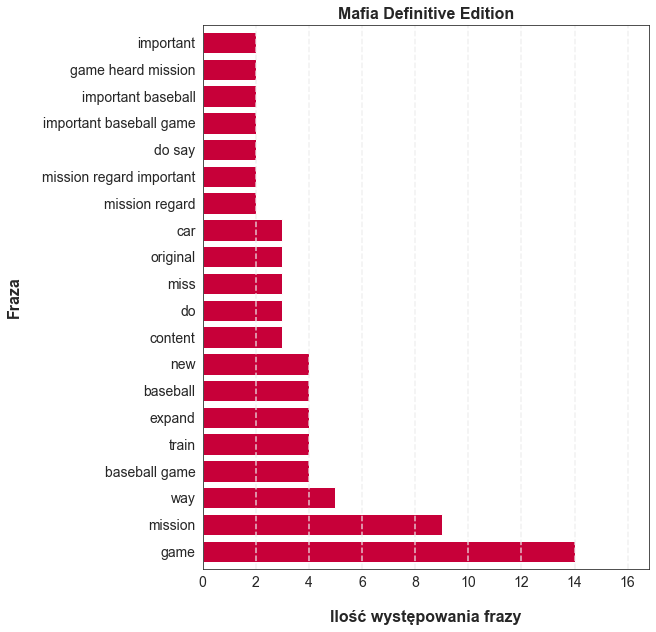

In [28]:
vectorizerMafia, XMafia, countvecMafia = calculateCountVectorizer(df_user_review_mafia_definitive_edition_pc_preprocessed,"text_preprocessing", 1, 3)
CountVectorizerplot(countvecMafia, 'Mafia Definitive Edition')

/Users/ncheba/Documents/Projekty/Metacritic/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/ncheba/Documents/Projekty/Metacritic/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


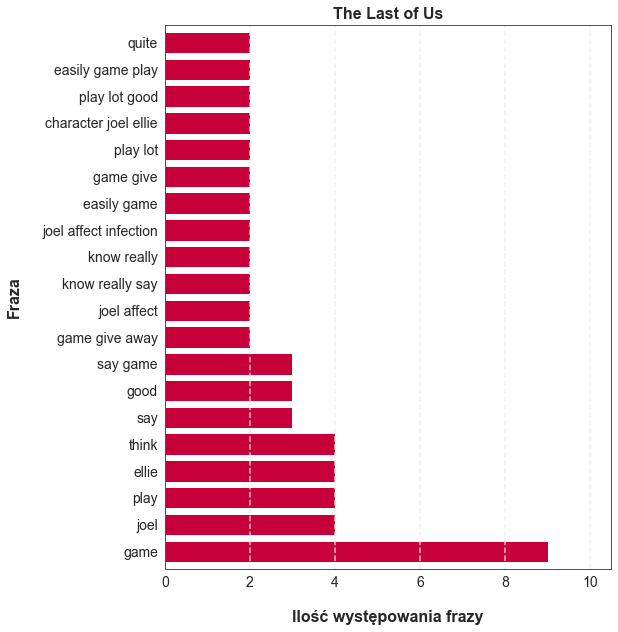

In [29]:
vectorizerTheLastOfUs, XTheLastOfUs, countvecTheLastOfUs = calculateCountVectorizer(df_user_review_The_last_of_us_preprocessed,"text_preprocessing", 1, 3)
CountVectorizerplot(countvecTheLastOfUs, 'The Last of Us')

/Users/ncheba/Documents/Projekty/Metacritic/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/ncheba/Documents/Projekty/Metacritic/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


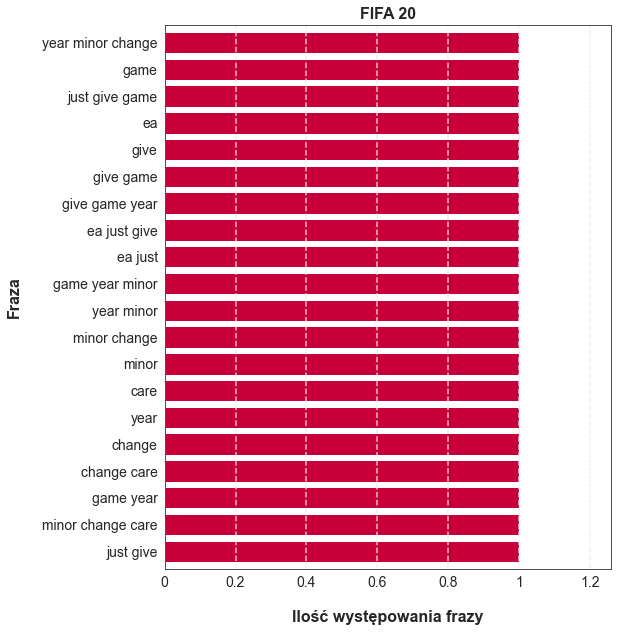

In [30]:
vectorizerFifa_20, XFifa_20, countvecFifa_20 = calculateCountVectorizer(df_user_review_Fifa_20_preprocessed,"text_preprocessing", 1, 3)
CountVectorizerplot(countvecFifa_20, 'FIFA 20')

Analiza skupień

In [13]:
from sklearn.cluster import KMeans
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data).groupby(clusters).mean()

    for i,r in df.iterrows():
        print('Skupienie {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))


def changeScoreToUMAP(df, columnInput, columnOutput):
    df[columnOutput] = np.where(
    df[columnInput] == "negatywna", 0, np.where(
    df[columnInput]  == "pozytywna",2 , 1))
    return df

In [32]:
#change score to present on UMAP plot
df_user_review_The_last_of_us_preprocessed = changeScoreToUMAP(df_user_review_The_last_of_us_preprocessed, "desc", "scoreNumber")
df_user_review_mafia_definitive_edition_pc_preprocessed = changeScoreToUMAP(df_user_review_mafia_definitive_edition_pc_preprocessed, "desc", "scoreNumber")
df_user_review_Fifa_20_preprocessed = changeScoreToUMAP(df_user_review_Fifa_20_preprocessed, "desc", "scoreNumber")

In [33]:
cluster_assignment_Mafia = KMeans(n_clusters=3).fit(XMafia).labels_
cluster_assignment_The_last_of_us = KMeans(n_clusters=3).fit(XTheLastOfUs).labels_
cluster_assignment_Fifa_20 = KMeans(n_clusters=3).fit(XFifa_20).labels_

In [34]:
import warnings
warnings.filterwarnings("ignore")
print("Mafia Definitive Edition")
get_top_keywords(XMafia, cluster_assignment_Mafia, vectorizerMafia.get_feature_names_out(), 20)

print("\nThe Last of Us")
get_top_keywords(XTheLastOfUs, cluster_assignment_The_last_of_us, vectorizerTheLastOfUs.get_feature_names(), 20)

print("\nFIFA 20")
get_top_keywords(XFifa_20, cluster_assignment_Fifa_20, vectorizerFifa_20.get_feature_names(), 20)

Mafia Definitive Edition
Skupienie 0
look,world,feel,really,great,character,original game,time,expand,car,play,just,remake,do,mission,good,story,like,original,game
Skupienie 1
story,yeah,nice,campaign,old,track,pretty,time,good,overall,feel,quite,well,new,bit,like,original,know,do,game
Skupienie 2
look,plot,original game,great,like,train,graphic,world,mission,do,free,just,city,expand,play,remake,good,story,original,game

The Last of Us
Skupienie 0
dog,way,good,feel,ellie,great,say,gameplay,joel,really,make,time,best,do,just,character,like,story,play,game
Skupienie 1
ellie,naughty dog,naughty,feel,dog,really,good,time,make,great,do,gameplay,just,expand,best,like,character,play,story,game
Skupienie 2
masterpiece,naughty dog,game play,naughty,dog,time,expand,like,really,best game,graphic,just,great,good,gameplay,character,best,play,story,game

FIFA 20
Skupienie 0
new,game game,do,gameplay,time,buy,expand,career mode,make,career,team,like,bad,just,ea,mode,year,player,play,game
Skupienie 1


In [18]:
import umap.umap_ as umap
def createUMAPPlots(df, title1, cluster_assignment, df2, column, title2, my_list):
    standard_embedding = umap.UMAP(random_state=42).fit_transform(df)

    f = plt.figure(1)
    scatter=plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s= 15, c=cluster_assignment, cmap='Set1' )
    for i in my_list:
        plt.text( standard_embedding[i,0],  standard_embedding[i,1], str(i))
    plt.title(title1, fontsize=12)
    plt.legend(*scatter.legend_elements())
    f.show()

    g= plt.figure(2)
    scatter = plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s= 15, c=df2[column], cmap='Set1')
    for i in my_list:
        plt.text( standard_embedding[i,0],  standard_embedding[i,1], str(i))
    plt.title(title2, fontsize=12)
    plt.legend(*scatter.legend_elements())
    g.show()

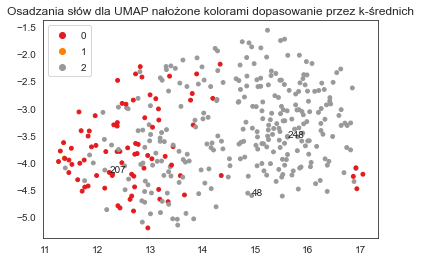

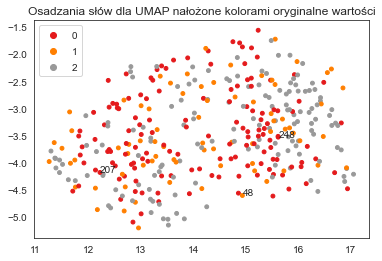

In [73]:
createUMAPPlots(XMafia,'Osadzania słów dla UMAP nałożone kolorami dopasowanie przez k-średnich', cluster_assignment_Mafia, df_user_review_mafia_definitive_edition_pc_preprocessed, "scoreNumber", 'Osadzania słów dla UMAP nałożone kolorami oryginalne wartości', [48,207,248] )

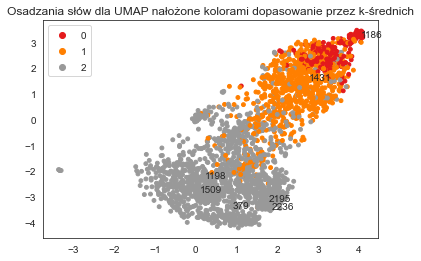

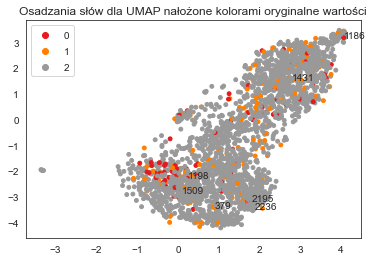

In [74]:
createUMAPPlots(XTheLastOfUs,'Osadzania słów dla UMAP nałożone kolorami dopasowanie przez k-średnich', cluster_assignment_The_last_of_us, df_user_review_The_last_of_us_preprocessed, "scoreNumber", 'Osadzania słów dla UMAP nałożone kolorami oryginalne wartości', [1186,1198,1431,1509,2195,2236,379] )

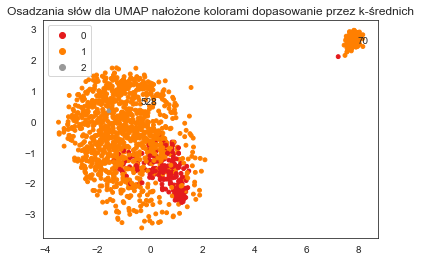

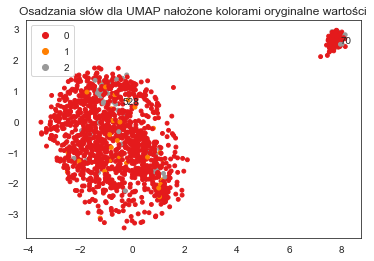

In [81]:
createUMAPPlots(XFifa_20,'Osadzania słów dla UMAP nałożone kolorami dopasowanie przez k-średnich', cluster_assignment_Fifa_20, df_user_review_Fifa_20_preprocessed, "scoreNumber", 'Osadzania słów dla UMAP nałożone kolorami oryginalne wartości', [70,528]  )

TF-IDF

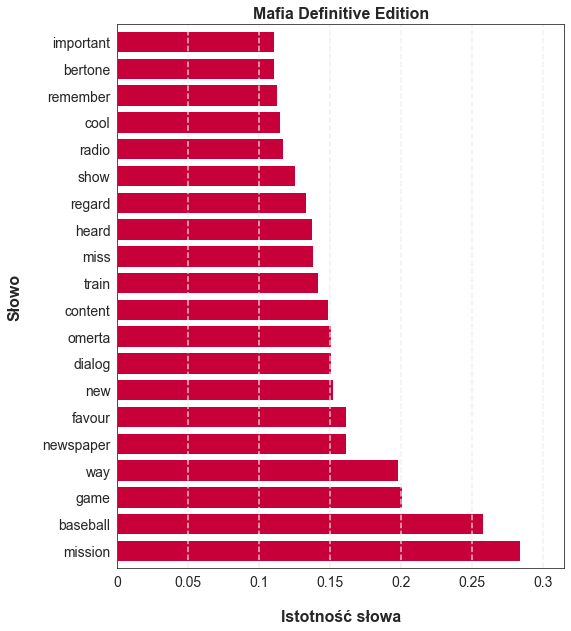

In [82]:
vectorizertdidfMafia, XMafia, tfidfMafia = calculateTFIDF(df_user_review_mafia_definitive_edition_pc_preprocessed,"text_preprocessing")
Tfidfrplot(tfidfMafia, 'Mafia Definitive Edition')

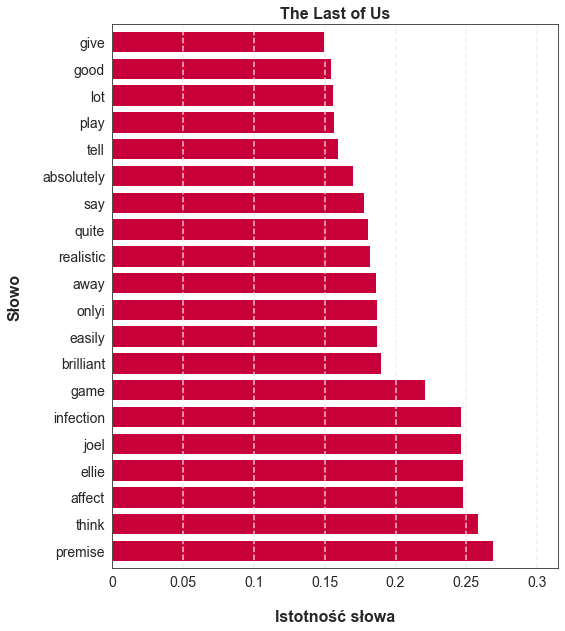

In [83]:
vectorizertdidflastofus, Xlastofus, tfidflastofus = calculateTFIDF(df_user_review_The_last_of_us_preprocessed,"text_preprocessing")
Tfidfrplot(tfidflastofus, 'The Last of Us')

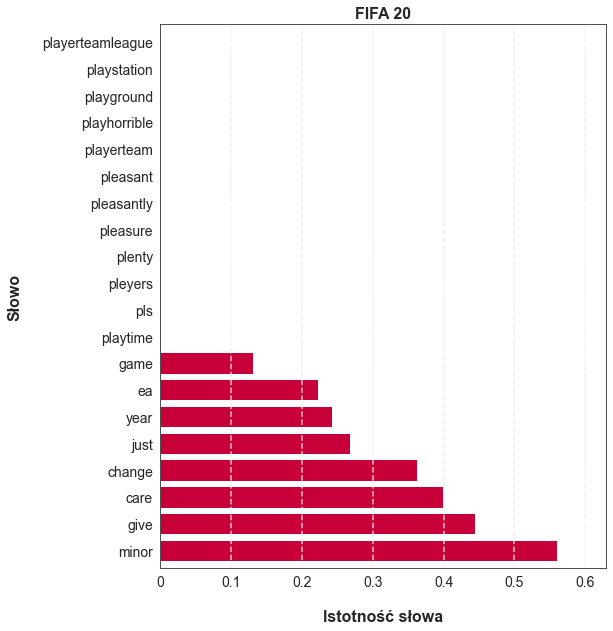

In [84]:
vectorizertdidffifa20, Xfifa20, tfidffifa20 = calculateTFIDF(df_user_review_Fifa_20_preprocessed,"text_preprocessing")
Tfidfrplot(tfidffifa20, 'FIFA 20')

In [85]:
cluster_assignment_Mafia = KMeans(n_clusters=3).fit(XMafia).labels_
cluster_assignment_The_last_of_us = KMeans(n_clusters=3).fit(Xlastofus).labels_
cluster_assignment_Fifa_20 = KMeans(n_clusters=3).fit(Xfifa20).labels_

In [86]:
import warnings
warnings.filterwarnings("ignore")
print("Mafia Definitive Edition")
get_top_keywords(XMafia, cluster_assignment_Mafia, vectorizertdidfMafia.get_feature_names_out(), 20)

print("\nThe Last of Us")
get_top_keywords(Xlastofus, cluster_assignment_The_last_of_us, vectorizertdidflastofus.get_feature_names(), 20)

print("\nFIFA 20")
get_top_keywords(Xfifa20, cluster_assignment_Fifa_20, vectorizertdidffifa20.get_feature_names(), 20)

Mafia Definitive Edition
Skupienie 0
release,ride,short,linear,mission,dead,play,freeride,walk,story,just,plot,do,version,city,train,world,free,original,game
Skupienie 1
think,love,amaze,do,like,recommend,hangar,nice,well,atmosphere,original,gameplay,play,graphic,best,story,great,remake,good,game
Skupienie 2
bad,look,great,thing,open,world,remake,car,do,play,good,character,just,original,mission,story,feel,like,really,game

The Last of Us
Skupienie 0
best,naughty,dog,gameplay,say,ellie,time,joel,feel,great,make,do,good,character,really,just,like,play,story,game
Skupienie 1
far,year,buy,just,naughty,dog,generation,video,gameplay,amaze,time,masterpiece,perfect,great,character,graphic,story,play,best,game
Skupienie 2
review,amazing,best,really,naughty,like,love,dog,perfect,time,just,graphic,masterpiece,play,character,good,great,gameplay,story,game

FIFA 20
Skupienie 0
football,do,team,pay,good,win,new,time,make,like,gameplay,money,buy,player,just,play,ea,year,bad,game
Skupienie 1
buy,compl

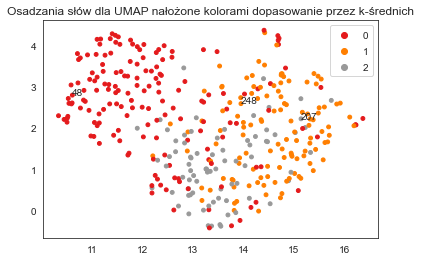

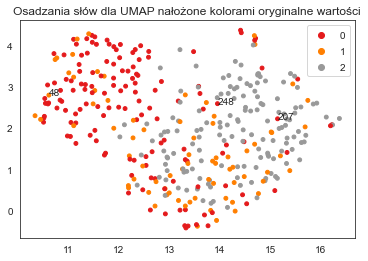

In [87]:
createUMAPPlots(XMafia,'Osadzania słów dla UMAP nałożone kolorami dopasowanie przez k-średnich', cluster_assignment_Mafia, df_user_review_mafia_definitive_edition_pc_preprocessed, "scoreNumber", 'Osadzania słów dla UMAP nałożone kolorami oryginalne wartości' , [48,207,248])

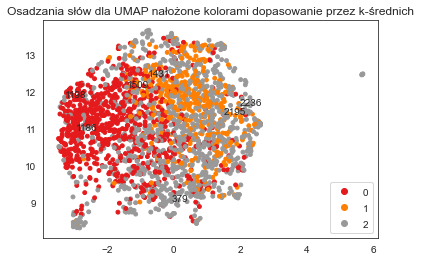

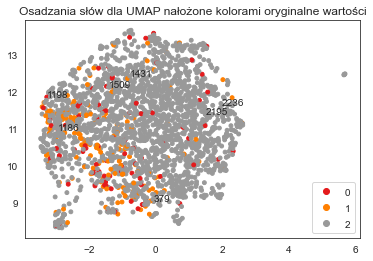

In [88]:
createUMAPPlots(Xlastofus,'Osadzania słów dla UMAP nałożone kolorami dopasowanie przez k-średnich', cluster_assignment_The_last_of_us, df_user_review_The_last_of_us_preprocessed, "scoreNumber", 'Osadzania słów dla UMAP nałożone kolorami oryginalne wartości', [1186,1198,1431,1509,2195,2236,379] )

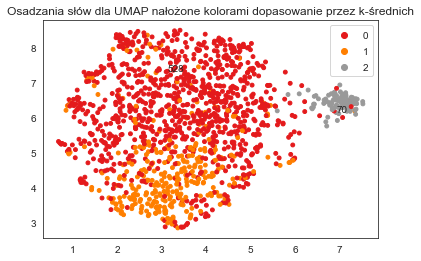

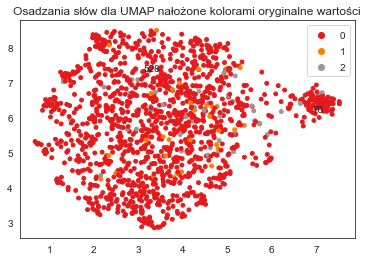

In [89]:
createUMAPPlots(Xfifa20,'Osadzania słów dla UMAP nałożone kolorami dopasowanie przez k-średnich', cluster_assignment_Fifa_20, df_user_review_Fifa_20_preprocessed, "scoreNumber", 'Osadzania słów dla UMAP nałożone kolorami oryginalne wartości', [70,528] )

BERT

In [14]:
#change score to present on UMAP plot
df_user_review_The_last_of_us = changeScoreToUMAP(df_user_review_The_last_of_us, "desc", "scoreNumber")
df_user_review_mafia_definitive_edition_pc = changeScoreToUMAP(df_user_review_mafia_definitive_edition_pc, "desc", "scoreNumber")
df_user_review_Fifa_20 = changeScoreToUMAP(df_user_review_Fifa_20, "desc", "scoreNumber")

In [15]:
#BERT model
from sentence_transformers import SentenceTransformer

def TransformerBERTNLIMEANTOKENS(df, column):

    embedder = SentenceTransformer('bert-large-nli-mean-tokens')
    corpus_embeddings = embedder.encode(df[column])
    return embedder, corpus_embeddings

In [15]:
#Mafia Embeddings
embedderMafia, MafiaEmbeddings = TransformerBERTNLIMEANTOKENS(df_user_review_mafia_definitive_edition_pc, "content")


In [21]:
#The last of us Embeddings
embedderTheLastofUs, TheLastofUsEmbeddings = TransformerBERTNLIMEANTOKENS(df_user_review_The_last_of_us, "content")

In [29]:
#FIFA Embeddings
embedderFifa20, Fifa20Embeddings = TransformerBERTNLIMEANTOKENS(df_user_review_Fifa_20, "content")

In [25]:
#cluster assignment the last of us
cluster_assignment_The_last_of_us_BERT = KMeans(n_clusters=3).fit(TheLastofUsEmbeddings).labels_

In [37]:
#cluster assignment fifa20
cluster_assignment_fifa20_BERT = KMeans(n_clusters=3).fit(Fifa20Embeddings).labels_

In [30]:
#cluster assignment bert
cluster_assignment_Mafia_BERT = KMeans(n_clusters=3).fit(MafiaEmbeddings).labels_

NameError: name 'MafiaEmbeddings' is not defined

In [ ]:
createUMAPPlots(MafiaEmbeddings,'Osadzania słów dla UMAP nałożone kolorami dopasowanie przez k-średnich', cluster_assignment_Mafia_BERT, df_user_review_mafia_definitive_edition_pc, "scoreNumber", 'Osadzania słów dla UMAP nałożone kolorami oryginalne wartości', [48,207,248] )

/var/folders/gt/t4t7vkc10wj1379qplxkdq9h0000gn/T/ipykernel_20842/4059773890.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
/var/folders/gt/t4t7vkc10wj1379qplxkdq9h0000gn/T/ipykernel_20842/4059773890.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.show()


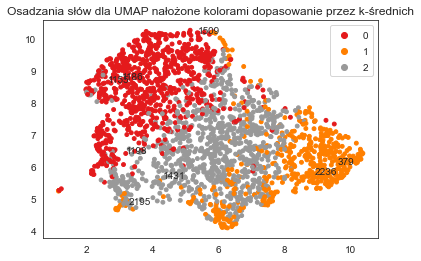

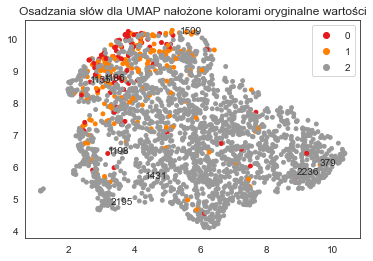

In [39]:
createUMAPPlots(TheLastofUsEmbeddings,'Osadzania słów dla UMAP nałożone kolorami dopasowanie przez k-średnich', cluster_assignment_The_last_of_us_BERT, df_user_review_The_last_of_us, "scoreNumber", 'Osadzania słów dla UMAP nałożone kolorami oryginalne wartości', [1186,1198,1431,1509,2195,2236,379, 1155]  )

/var/folders/gt/t4t7vkc10wj1379qplxkdq9h0000gn/T/ipykernel_20842/4059773890.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
/var/folders/gt/t4t7vkc10wj1379qplxkdq9h0000gn/T/ipykernel_20842/4059773890.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.show()


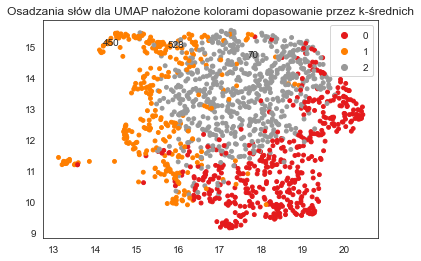

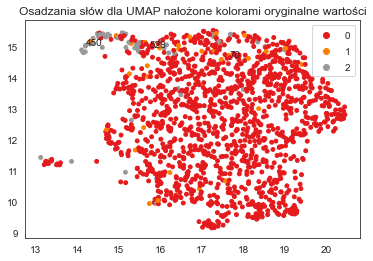

In [40]:
createUMAPPlots(Fifa20Embeddings,'Osadzania słów dla UMAP nałożone kolorami dopasowanie przez k-średnich', cluster_assignment_fifa20_BERT, df_user_review_Fifa_20, "scoreNumber", 'Osadzania słów dla UMAP nałożone kolorami oryginalne wartości', [70,528, 450]  )